# Reconhecimento de Sinais LIBRAS


Trabalho da disciplina Redes Neurais Artificias - UFERSA

In [ ]:
from google.colab import drive
#para autenticar o caminho
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Importando bibliotecas

In [ ]:
import zipfile
import os
from io import BytesIO  # reconhecer numeros binarios e converter
from PIL import Image
import matplotlib.pyplot as plt  # plotar graficos
import os  # SO do computador
import shutil  # para manipulação de arquivos e diretorios
import pandas as pd
from sklearn.preprocessing import StandardScaler  # padronizar os dados
import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from os.path import join
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import os, sys
from scipy import ndimage
import cv2
import matplotlib.pyplot as plt
import itertools
import scipy.stats
import tensorflow as tf
from keras import applications, optimizers, Input
from keras.models import Sequential, Model
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.multiclass import unique_labels

zip_path = '/content/drive/MyDrive/redes/dataSet_colorido_libras.zip'
extract_path = '/content/dataSet_colorido_libras'

# Extrair o conteúdo do arquivo ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Listar os arquivos no diretório de extração
extracted_files = os.listdir(extract_path)
print(f'Arquivos extraídos: {extracted_files}')


Arquivos extraídos: ['dataSet_colorido_libras']


## 2. Manipulação do Dataset

In [ ]:
folder = '/content/dataSet_colorido_libras/dataSet_colorido_libras/30 FPS/30 FPS/train'
#mudei essas linhas de baixo pois estava em 120
image_width = 120
image_height = 213
nova_altura = 213
nova_largura = 120
channels = 3

train_files = []
i=0
for image in ['bus_renamed', 'bank_renamed', 'car_renamed', 'formation_renamed', 'hospital_renamed','I_renamed', 'man_renamed', 'motorcycle_renamed', 'my_renamed', 'supermarket_renamed', 'we_renamed',
             'woman_renamed', 'you_renamed', 'you (plural)_renamed', 'your_renamed']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(image)) if os.path.isfile(os.path.join(folder + '/' + str(image), f))]
    for _file in onlyfiles:
        train_files.append(_file)

dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels),
                     dtype=np.float32)
y_dataset = []

i = 0
for image in ['bus_renamed', 'bank_renamed', 'car_renamed', 'formation_renamed', 'hospital_renamed','I_renamed', 'man_renamed', 'motorcycle_renamed', 'my_renamed', 'supermarket_renamed', 'we_renamed',
             'woman_renamed', 'you_renamed', 'you (plural)_renamed', 'your_renamed']:
    onlyfiles = [f for f in os.listdir(folder + '/' + str(image)) if os.path.isfile(os.path.join(folder + '/' + str(image), f))]
    for _file in onlyfiles:
        img = load_img(folder + '/' +  str(image) + '/' + _file)  # this is a PIL image
        img.thumbnail((image_width, image_height))
        img = cv2.resize(img_to_array(img) , (nova_largura, nova_altura))
        x = np.array(img)
        dataset[i] = x
        mapping = {'bus_renamed': 0 , 'bank_renamed': 1 , 'car_renamed' : 2 , 'formation_renamed': 3 , 'hospital_renamed' : 4 ,'I_renamed' : 5 , 'man_renamed' : 6 , 'motorcycle_renamed' : 7 , 'my_renamed' : 8 , 'supermarket_renamed' : 9 , 'we_renamed' : 10 ,
             'woman_renamed'  : 11 , 'you_renamed' : 12 , 'you (plural)_renamed' : 13  , 'your_renamed' : 14 }
        y_dataset.append(mapping[image])
        i += 1
        if i == 500:
            print("%d images to array" % i)
            break
print("All images to array!")


500 images to array
All images to array!


### 2.1 Normalizando

In [ ]:
dataset = dataset.astype('float32')
dataset /= 255

### 2.2 Exemplo de imagem do dataset

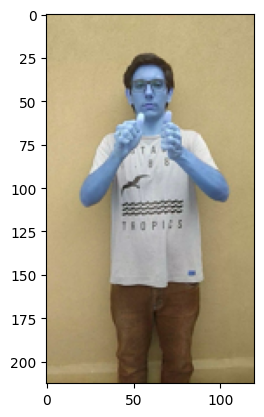

In [ ]:
pixels = np.array(dataset[0], dtype='float32')
plt.imshow(cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB))
plt.show()

### 2.3 Quantidade de classes

In [ ]:
# categorical values
n_classes = len(set(y_dataset))
print(n_classes)
y_dataset_ = to_categorical(y_dataset, n_classes)

15


### 2.4 Dividindo o dataset em 80% treino e 20% teste

In [ ]:
# Trim dataset to match the size of y_dataset_
dataset_trimmed = dataset[:len(y_dataset_)]
# Splitting into training and test sets
X_train, X_test, y_train, y_test = train_test_split(dataset_trimmed, y_dataset_, test_size=0.2)
print("Train set size: {0}, Test set size: {1}".format(len(X_train), len(X_test)))

Train set size: 5716, Test set size: 1430


## 3. Modelo CNN

In [ ]:
# Criar o modelo
model = Sequential()

model.add(BatchNormalization(input_shape=(image_height, image_width, 3)))
model.add(Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.2))  # Adiciona a camada de dropout

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))  # Adiciona a camada de dropout
model.add(Dense(15, activation='softmax'))  # Especifica 'softmax' como a função de ativação


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 213, 120, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 213, 120, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 106, 60, 256)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 106, 60, 256)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 60, 128)      295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 30, 128)       0

### 3.1 Compilando o modelo

In [ ]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

### 3.2 Treinando o modelo

In [ ]:
# Configurar EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
# Treinar o modelo
history = model.fit(X_train,y_train,validation_split= 0.2, epochs=50, callbacks=[early_stopping], batch_size=64)

Epoch 1/50
72/72 [==============================] - 59s 621ms/step - loss: 2.2233 - accuracy: 0.5930 - val_loss: 2.3177 - val_accuracy: 0.5979
Epoch 2/50
72/72 [==============================] - 37s 510ms/step - loss: 1.1361 - accuracy: 0.6371 - val_loss: 1.6434 - val_accuracy: 0.6040
Epoch 3/50
72/72 [==============================] - 37s 515ms/step - loss: 0.8578 - accuracy: 0.7113 - val_loss: 1.1250 - val_accuracy: 0.6486
Epoch 4/50
72/72 [==============================] - 37s 507ms/step - loss: 0.6815 - accuracy: 0.7688 - val_loss: 0.6933 - val_accuracy: 0.7885
Epoch 5/50
72/72 [==============================] - 37s 507ms/step - loss: 0.5966 - accuracy: 0.7927 - val_loss: 0.4924 - val_accuracy: 0.8715
Epoch 6/50
72/72 [==============================] - 37s 509ms/step - loss: 0.5334 - accuracy: 0.8104 - val_loss: 0.4570 - val_accuracy: 0.8689
Epoch 7/50
72/72 [==============================] - 36s 504ms/step - loss: 0.4922 - accuracy: 0.8279 - val_loss: 0.3534 - val_accuracy: 0.9065

## 4. Avaliação do modelo

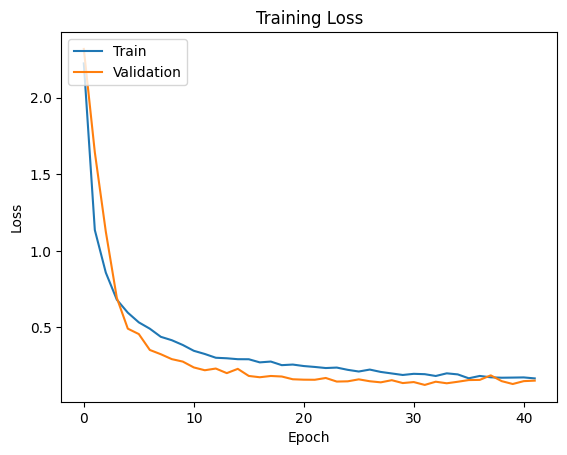

In [ ]:
# Visualizar a perda durante o treinamento
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
preds = model.predict(X_test)

45/45 [==============================] - 4s 54ms/step


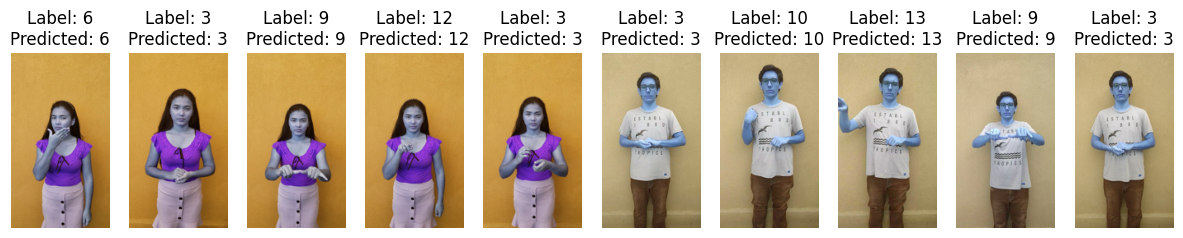

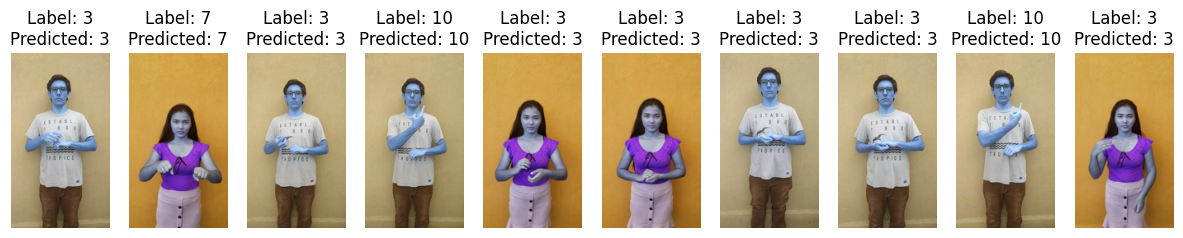

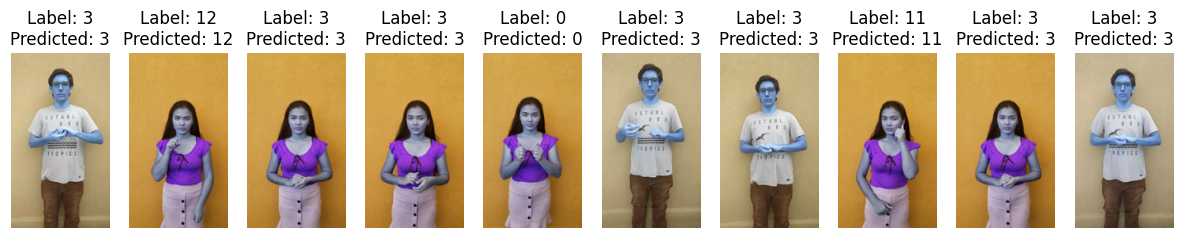

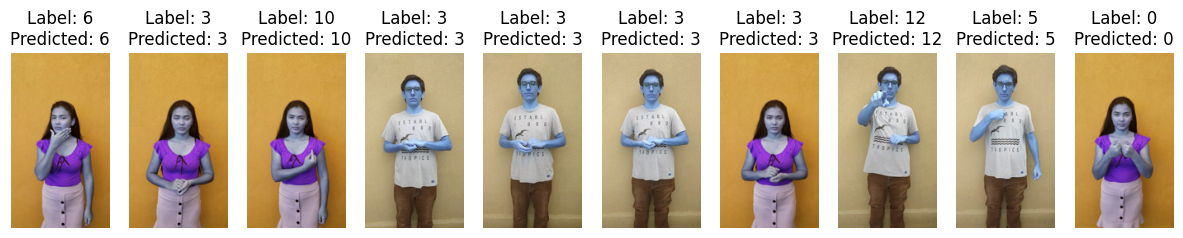

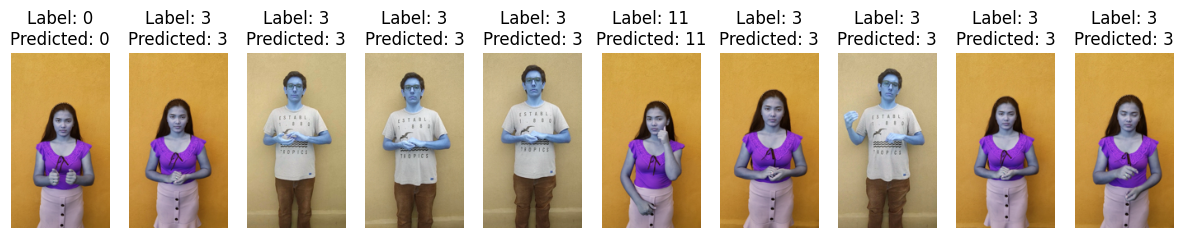

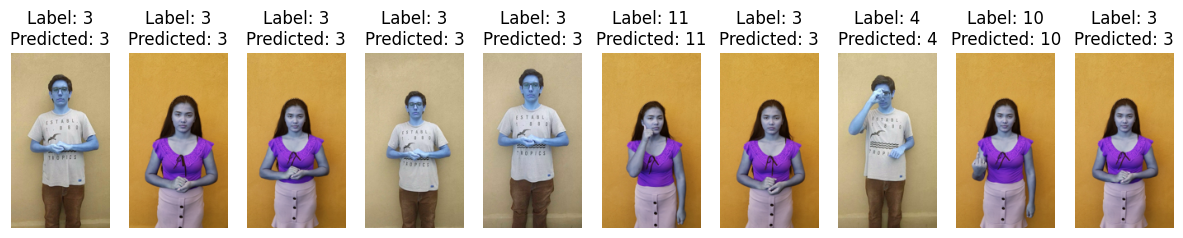

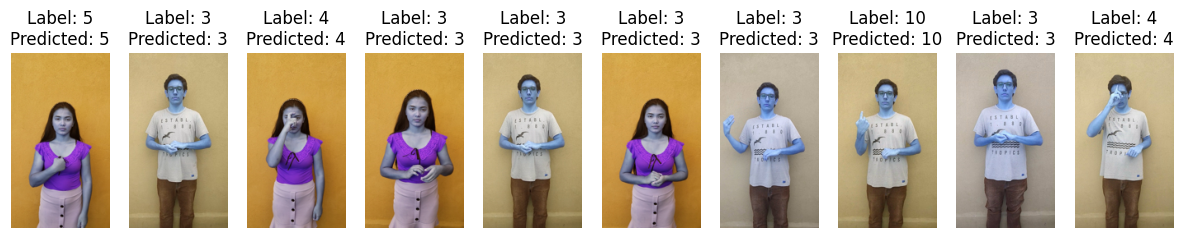

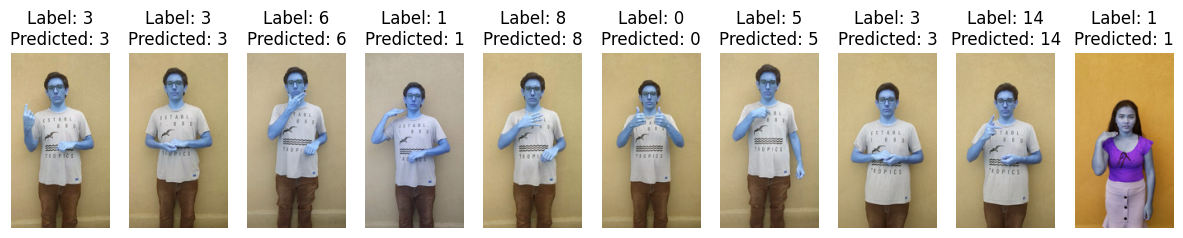

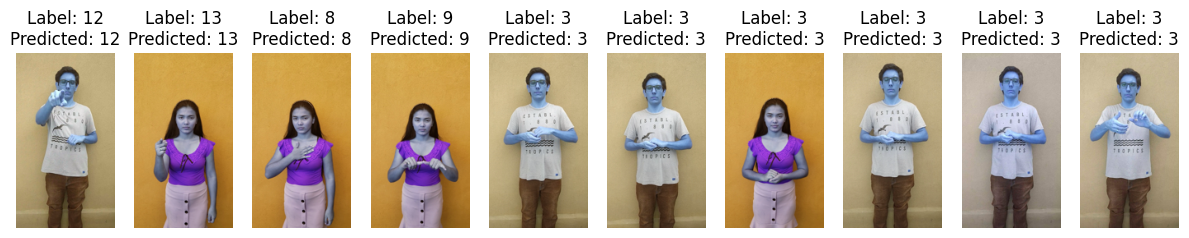

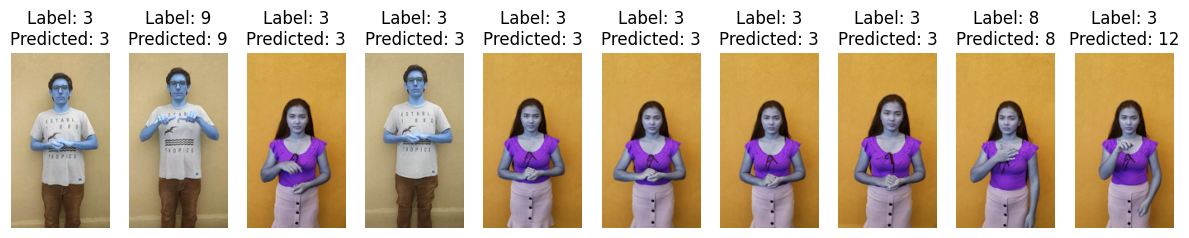

In [ ]:
totals_images = 10
for total in range(10):
    plt.figure(figsize=(15,15))
    for i in range(totals_images*total, totals_images*(total+1)):
        plt.subplot(1, totals_images, i + 1 - totals_images*total)
        plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB), cmap='gray')
        plt.title('Label: {}\nPredicted: {}'.format(np.argmax(y_test[i]), np.argmax(preds[i])))
        plt.axis('off')
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True class')
    plt.xlabel('Predicted class')

Confusion matrix, without normalization
[[ 60   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0  49   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   0   2   0   0   0   1   0   0   0   0   0   0   0]
 [  2   1   0 833   1   4   0   3   0   0   1   1   4   1   2]
 [  0   0   0   0  45   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0  22   0   0   0   0   0   0   0   0   0]
 [  0   0   0   3   0   0  33   0   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0  63   0   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0  37   0   0   0   0   0   0]
 [  0   0   0   1   0   0   0   0   0  55   0   0   0   0   0]
 [  0   0   0   4   0   0   0   0   0   0  54   0   0   0   0]
 [  0   1   0   1   0   0   0   0   0   0   0  28   1   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  32   0   3]
 [  0   0   0   3   0   0   0   0   0   0   0   0   0  44   0]
 [  0   0   0   1   0   0   0   0   0   0   0   0   0   0  28]]


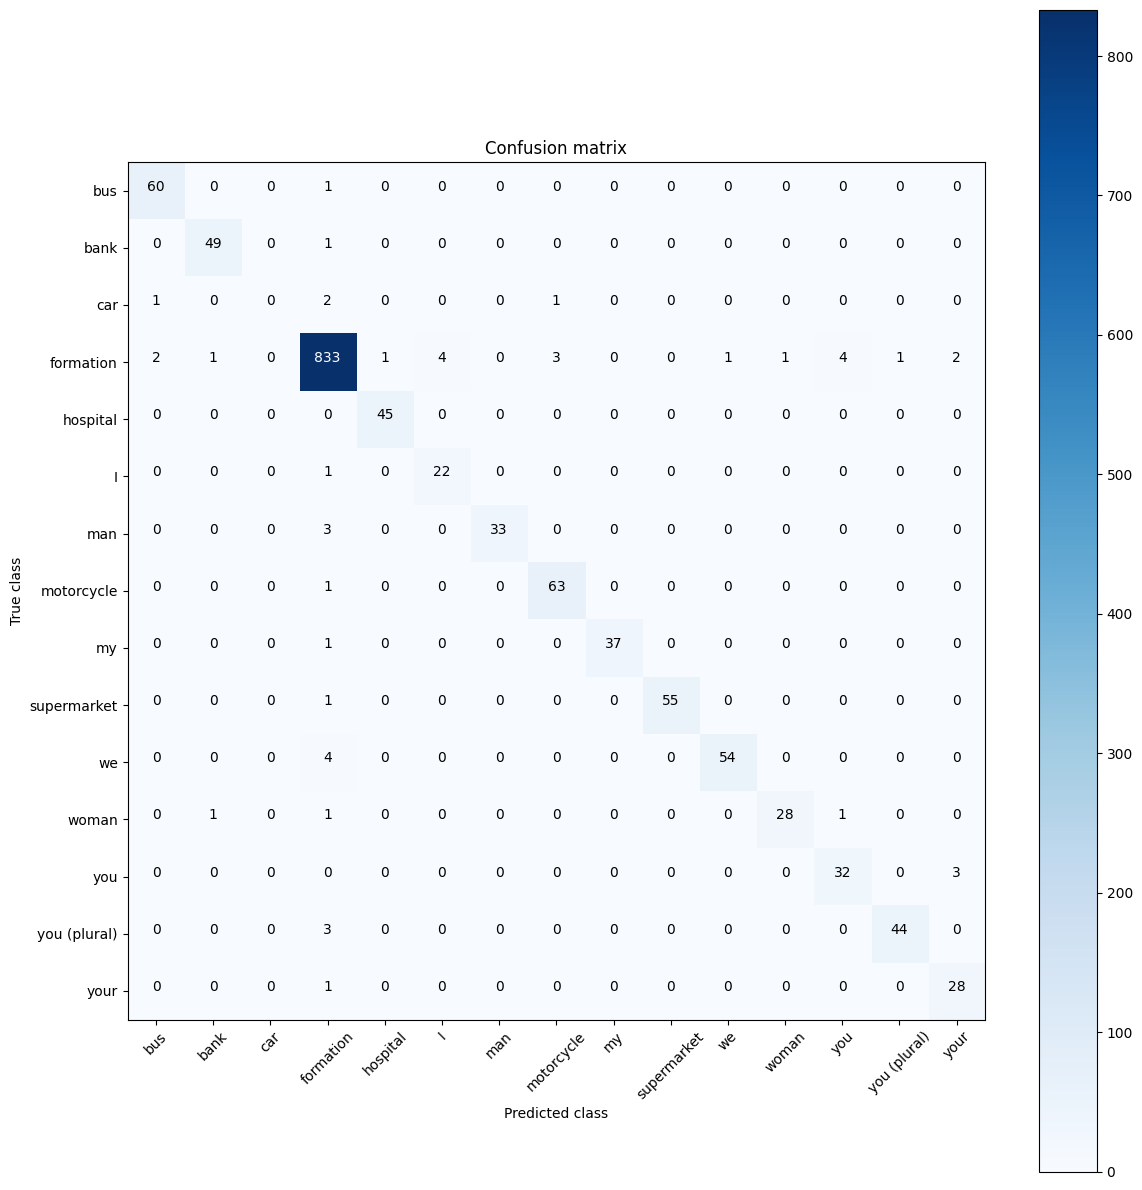

In [ ]:
y_test_ = [np.argmax(x) for x in y_test]
preds_ = [np.argmax(x) for x in preds]

cm = confusion_matrix(y_test_, preds_)
plt.figure(figsize= (12,12))
plot_confusion_matrix(cm, classes=['bus', 'bank', 'car', 'formation', 'hospital', 'I', 'man', 'motorcycle', 'my', 'supermarket', 'we', 'woman', 'you', 'you (plural)', 'your']
, title='Confusion matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(preds, axis=1))
print("Acurácia: {:.2f}%".format(accuracy * 100))

Acurácia: 96.71%


In [ ]:
# prompt: save this is a model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pandas as pd
historico = pd.DataFrame(history.history)

In [ ]:
historico.head()

loss  accuracy  val_loss  val_accuracy
0  2.223258  0.592957  2.317710      0.597902
1  1.136066  0.637139  1.643393      0.604021
2  0.857825  0.711286  1.124960      0.648601
3  0.681543  0.768810  0.693284      0.788462
4  0.596634  0.792651  0.492370      0.871503

In [ ]:
historico.to_csv('historico.csv')